# ARG Functions

This file contains some general ARG functions that may be useful for various applications. For now I'm keeping it separate from the algorithm documents, but eventually we will want to combine.

In [1]:
import msprime
import tskit
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt
import graphviz

def plot_arg(ts):
    """
    Plot ARG using GraphViz. Variation on code from Anastasia Ignatieva 
    (https://github.com/tskit-dev/tutorials/issues/43). I would eventually like
    to create my own plotting function, but for now this works.
    """
    
    dot = graphviz.Digraph(strict=False)
    nodes = []

    # Internal nodes
    itr = iter(range(ts.num_samples, ts.num_nodes))
    for i in itr:
        if ts.node(i).flags == msprime.NODE_IS_RE_EVENT:
            # Only add one of the recombination nodes and make the other one invisible
            with dot.subgraph() as s:
                s.attr(rank = 'same')
                s.node(str(i), **{'shape': 'rectangle'}, label = str(i) + "/" + str(i+1))
                nodes.append(i)
                next(itr, None)
        else:
            dot.node(str(i), **{'shape': 'circle'})
            nodes.append(i)

    # Add sample nodes
    with dot.subgraph() as s:
        s.attr(rank = 'same')
        for n in ts.samples(): 
            s.node(str(n), **{'shape': 'doublecircle'})

    nodes = sorted(nodes)
    remove_nodes = []

    # Add edges
    check = [0,0]
    for e in ts.edges():
        ch = e.child
        pa = e.parent

        # Preventing duplicate edges
        if check == [pa, ch]:
            continue
        check = [pa, ch]

        # Check which edge to draw if there is a recombination
        if e.parent >= 1 and ts.node(pa).time == ts.node(pa-1).time and ts.node(pa).flags == ts.node(pa-1).flags == msprime.NODE_IS_RE_EVENT:
            ch = pa = -1
        elif e.child >= 1 and ts.node(ch).time == ts.node(ch-1).time and ts.node(ch).flags == ts.node(ch-1).flags == msprime.NODE_IS_RE_EVENT:
            ch -= 1

        if(ch >= 0 and pa >= 0):
            if ch >= 4 and pa == nodes[nodes.index(ch)+1]:
                remove_nodes.append(ch)

            if ts.first().interval.left >= e.left and ts.first().interval.right <= e.right and False:
                color = 'red'
                dot.edge(str(pa), str(ch), **{'arrowhead': 'none', 'color':color})
            else:
                color = 'black'
                dot.edge(str(pa), str(ch), **{'arrowhead': 'none', 'color':color})

    needed_connections = [x for x in nodes if x not in remove_nodes]
    for node in needed_connections[:-1]:
        dot.edge(str(nodes[nodes.index(node)+1]), str(node), weight='0', **{'style':'invis', 'arrowhead': 'none'})
    display(dot)

def ts_to_nx(ts, connect_recombination_nodes=False, recomb_nodes=[]):
    """
    Converts tskit tree sequence to networkx graph.
    """
    
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if connect_recombination_nodes:
                if recomb_nodes == []:
                    recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
                if v in recomb_nodes and recomb_nodes.index(v)%2 == 1:
                    v -= 1
                if k in recomb_nodes and recomb_nodes.index(k)%2 == 1:
                    k -= 1
                if v not in topology[k]:
                    topology[k].append(v)
            else:
                if v not in topology[k]:
                    topology[k].append(v)
    print(topology)
    nx_graph = nx.DiGraph(topology)
    return nx_graph

def group_loops(loops, plot=False):
    """
    Groups intersecting loops in list. Builds networkx graph based on the loop list. Determines
    if the nodes are connected through the graph. Returns a list of lists of loops.
    """
    
    num_loops = len(loops)
    if num_loops == 0:
        return []
    else:
        if num_loops > 1:
            build_instructions = []
            for loop in loops:
                for n in range(len(loop)):
                    if n == len(loop)-1:
                        a, b = loop[n], loop[0]
                    else:
                        a, b = loop[n], loop[n+1]
                    build_instructions.append([a, b])
            g = nx.Graph(build_instructions)
            grouped_nodes = list(nx.connected_components(g))
            if plot:
                nx.draw(g, with_labels=True)
            grouped_loops = [[] for i in range(len(grouped_nodes))]
            for loop in loops:
                for i in range(len(grouped_loops)):
                    if loop[0] in grouped_nodes[i]:
                        grouped_loops[i].append(loop)
            return grouped_loops
        else:
            return [loops]

def locate_loops(ts, cycle_root=-1):
    """
    Finds loops within the ARG. I thought that it would be easiest to utilize functions from
    networkx package. Identifies recombination events, converts the tree sequence into a networkx
    graph. The paired recombination nodes are merged together in this graph. Converts graph to 
    undirected, then calculates cycle basis. This does not identify 'bubbles', so we need to add
    an extra step to this.
    """
    
    if cycle_root < 0:
        cycle_root = ts.node(ts.num_nodes-1).id
    edges = ts.tables.edges
    parent_list = list(edges.parent)
    child_list = list(edges.child)
    recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
    g = ts_to_nx(ts=ts, connect_recombination_nodes=True, recomb_nodes=recomb_nodes)
    g = g.to_undirected()
    loop_list = nx.cycle_basis(g, root=cycle_root)
    if len(loop_list) != len(recomb_nodes)/2:
        for node in recomb_nodes[::2]:
            parent = parent_list[child_list.index(node)]
            if parent == parent_list[child_list.index(node+1)]:
                loop_list.append([node, parent])  
    return loop_list

## Outlining the algorithm

I thought that it would be easiest to utilize functions from networkx package, so much of this algorithm revolves around that aspect. First,  we identify all of the recombination events. When building the networkx graph from the tree sequence, we merge the paired recombination nodes into a single node in the graph. Next, we converts graph to undirected and then calculate its cycle basis. From my understanding of math, this appears to be the set of loops that we are interested in (correct me if I am wrong). One obvious overloook is that by collapsing the paired recombination nodes together, we lose 'bubble'-style loops, so we need to add an extra step that checks that every recombination node has an associated loop. Once we have the loops, we group then based on whether they are intersecting and therefore must be worked through together.

Seed: 1769


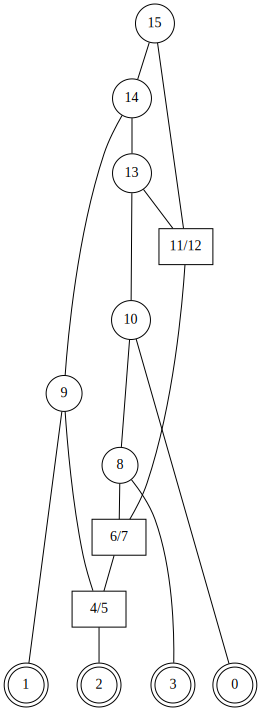

3 Loops Found: [[11, 13, 14, 15], [11, 6, 8, 10, 13], [9, 4, 6, 8, 10, 13, 14]]
[[[11, 13, 14, 15], [11, 6, 8, 10, 13], [9, 4, 6, 8, 10, 13, 14]]]


In [2]:
rs = random.randint(0,10000)

ts = msprime.sim_ancestry(
    samples=2,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=rs
)

print("Seed:", rs)
plot_arg(ts)

loops = locate_loops(ts=ts)
print(len(loops), "Loops Found:", loops)
grouped_loops = group_loops(loops=loops)
print(grouped_loops)

## Example of Strange Behavior

I added a "cycle_root" parameter to locate_loops() which I set to the GMRCA by default. This seems to help it find the small set of cycles, but this doesn't work for this one. Instead it needs "cycle_root" to be 9. This brings up the question of how to generally set the "cycle_root" and whether it is truely important to have the smallest set as long as all branches are included in the calculation. It seems like a very central "cycle_root" might give us the best result, but that is a complete guess. 9 is the only node that works.

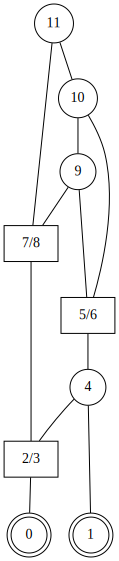

Loops Found From cycle_root 11: [[5, 9, 10], [7, 9, 10, 11], [7, 2, 4, 5, 10, 11]]
Loops Found From cycle_root 9: [[5, 10, 9], [7, 11, 10, 9], [5, 4, 2, 7, 9]]


In [80]:
ts = msprime.sim_ancestry(
    samples=1,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=3107
)
plot_arg(ts)
loops = locate_loops(ts=ts)
print("Loops Found From cycle_root 11:", loops)
loops = locate_loops(ts=ts, cycle_root=9)
print("Loops Found From cycle_root 9:", loops)

## New Plotting Method

In [2]:
from IPython.display import IFrame

rs = random.randint(0,10000)
    
ts = msprime.sim_ancestry(
    samples=3,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=rs
)


width = 700 - 200
height = 600 - 100

print(rs)


w_spacing = width / (ts.num_samples - 1)
h_spacing = height / (ts.num_nodes - ts.num_samples - np.count_nonzero(ts.tables.nodes.flags == 131072)/2)

ordered_nodes = []
for node in ts.first().nodes(order="minlex_postorder"):
    if node < ts.num_samples:
        ordered_nodes.append(node)

nodes = []
node_index = 0
fy = 0
skip_recomb = True
recomb_nodes = []
mc_nodes = []
for node in ts.tables.nodes:
    if node.flags == 1:
        nodes.append({"id": node_index, "label": node_index, "flag": node.flags, "fx": ordered_nodes.index(node_index)*w_spacing+100, "fy": height-(fy*h_spacing-50)})
    elif node.flags == 131072:
        if skip_recomb:
            fy += 1
            child = ts.tables.edges[np.where(ts.tables.edges.parent == node_index)[0]].child[0]
            nodes.append({"id": node_index, "label": str(node_index)+"/"+str(node_index+1), "flag": node.flags, "xref": child, "fy": height-(fy*h_spacing)+50})
            skip_recomb = False
        else:
            recomb_nodes.append(node_index)
            skip_recomb = True
    elif node.flags == 262144:
        mc_nodes.append(node_index)
        fy += 1
        child = ts.tables.edges[np.where(ts.tables.edges.parent == node_index)[0]].child[0]
        nodes.append({"id": node_index, "label": node_index, "flag": node.flags, "xref": child, "fy": height-(fy*h_spacing)+50})
    else:
        fy += 1
        nodes.append({"id": node_index, "label": node_index, "flag": node.flags, "fy": height-(fy*h_spacing)+50})
    node_index += 1

already_found = []
links = []
for edge in ts.tables.edges:
    direction = ""
    if edge.parent in recomb_nodes:
        pass
    else:
        if edge.child in recomb_nodes:
            c = edge.child - 1
        else:
            c = edge.child
        if edge.parent in mc_nodes:
            if edge.parent not in already_found:
                already_found.append(edge.parent)
                direction = 0
            else:
                direction = 1
        links.append({"source": edge.parent, "target": c, "direction":direction})

        
with open("arg.js", "w") as outfile:
    outfile.write("var graph = {\n")
    outfile.write("\tnodes: " + str(nodes) + ",\n")
    outfile.write("\tlinks: " + str(links) + "\n")
    outfile.write("};")
    
display(IFrame(src='./index.html', width=800, height=650))

print(ts.draw_text())

8869


15463.91┊      16     ┊       16     ┊        16    ┊  
        ┊     ┏━┻━━┓  ┊     ┏━━┻━━┓  ┊      ┏━━┻━━┓ ┊  
14226.18┊    15    ┃  ┊    15     ┃  ┊     15     ┃ ┊  
        ┊     ┃    ┃  ┊   ┏━┻━┓   ┃  ┊   ┏━━┻━━┓  ┃ ┊  
13669.44┊    14    ┃  ┊  14   ┃   ┃  ┊  14     ┃  ┃ ┊  
        ┊   ┏━┻━┓  ┃  ┊ ┏━┻┓  ┃   ┃  ┊ ┏━┻━┓   ┃  ┃ ┊  
10615.88┊  13   ┃  ┃  ┊ 13 ┃  ┃   ┃  ┊ 13  ┃   ┃  ┃ ┊  
        ┊ ┏━┻┓  ┃  ┃  ┊ ┃  ┃  ┃   ┃  ┊ ┃   ┃   ┃  ┃ ┊  
8191.67 ┊ ┃ 11  ┃  ┃  ┊ ┃  ┃ 12   ┃  ┊ ┃   ┃  12  ┃ ┊  
        ┊ ┃  ┃  ┃  ┃  ┊ ┃  ┃  ┃   ┃  ┊ ┃   ┃   ┃  ┃ ┊  
7427.27 ┊ ┃  ┃ 10  ┃  ┊ ┃ 10  ┃   ┃  ┊ ┃  10   ┃  ┃ ┊  
        ┊ ┃  ┃  ┃  ┃  ┊ ┃  ┃  ┃   ┃  ┊ ┃  ┏┻┓  ┃  ┃ ┊  
4425.76 ┊ ┃  ┃  ┃  9  ┊ ┃  ┃  ┃   9  ┊ ┃  ┃ ┃  ┃  9 ┊  
        ┊ ┃  ┃  ┃ ┏┻┓ ┊ ┃  ┃  ┃  ┏┻┓ ┊ ┃  ┃ ┃  ┃  ┃ ┊  
3178.96 ┊ ┃  ┃  ┃ ┃ 7 ┊ ┃  ┃  ┃  ┃ 7 ┊ ┃  ┃ 8  ┃  ┃ ┊  
        ┊ ┃  ┃  ┃ ┃ ┃ ┊ ┃  ┃  ┃  ┃ ┃ ┊ ┃  ┃ ┃  ┃  ┃ ┊  
1008.55 ┊ ┃  6  ┃ ┃ ┃ ┊ ┃  ┃  6  ┃ ┃ ┊ ┃  ┃ ┃  6  ┃ ┊  
        ┊ ┃ ┏┻┓ ┃ ┃ ┃ ┊ ┃  ┃ ┏┻┓ ┃ ┃ ┊ ┃  ┃ ┃ ┏┻

In [442]:
ts.tables.edges[np.where(ts.tables.edges.parent == 8)[0]]

id,left,right,parent,child,metadata
0,0.00000000,2000.00000000,8,3,b''
1,1677.00000000,2000.00000000,8,7,b''


In [375]:
tables

ValueError: DataFrame constructor not properly called!

In [569]:
flags = list(ts.tables.nodes.flags)
d3_table = pd.DataFrame({"id":range(len(flags)), "flags":flags})
d3_table

,id,flags
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0
